# Free Drawn Spirals

For understanding the code in detail, please refer to the [PD_classification_Kamble](PD_classification_Kamble.ipynb) notebook.

We used this: [Dataset](https://www.kaggle.com/datasets/kmader/parkinsons-drawings/).

In [1]:
# import module
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.morphology import skeletonize
from numba.typed import List
from utils import thin_spiral_image_with_custom_cut, find_spiral_point, \
         trace_spiral, get_angle_dist2, angle_cont_func, plt_traced
from scipy import signal
from sklearn.linear_model import LinearRegression
from scipy.ndimage import gaussian_filter1d
import os
import plantcv.plantcv.morphology.prune as prune

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

import random

In [2]:

# Store Pdf with convert_from_path function
path = r'C:\Users\Baumann\Documents\UU\03_semester\AIA\project\Varalakshmi\drawings\spiral'



V01HE01.png


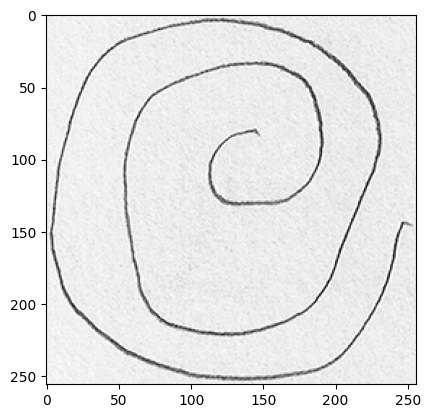

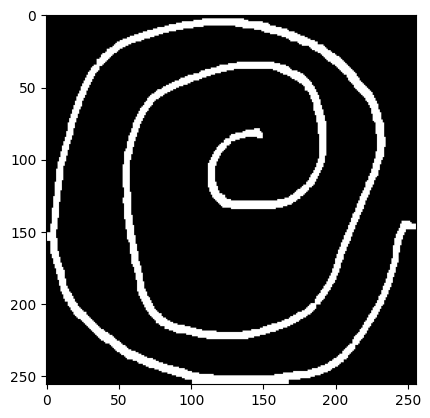

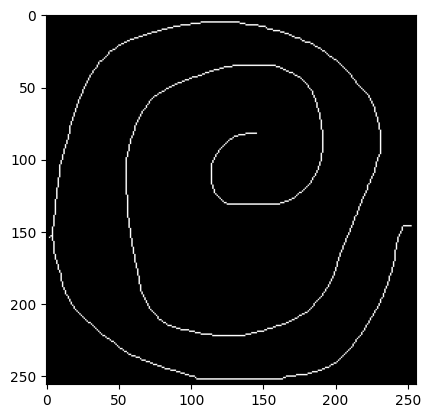

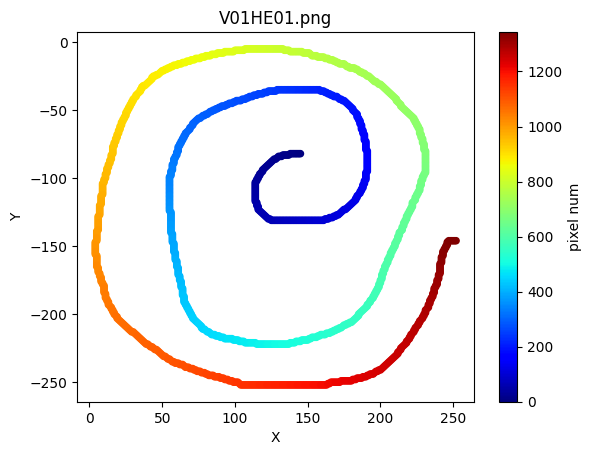

V01HE02.png
V01HE03.png
V01PE01.png
V01PE02.png
V01PE03.png
V02HE01.png
V02HE02.png
V02HE03.png
V02PE01.png
V02PE02.png
V02PE03.png
V03HE1.png
V03HE2.png
V03HE3.png
V03PE01.png
V03PE02.png
V03PE03.png
V03PE04.png
V03PE05.png
V03PE06.png
V03PE07.png
V03PE08.png
V03PE09.png
V04HE01.png
V04HE02.png
V04HE03.png
V04PE01.png
V04PE02.png
V04PE03.png
V05HE01.png
V05HE02.png
V05HE03.png
V05PE01.png
V05PE02.png
V05PE03.png
V06HE01.png
V06HE02.png
V06HE03.png
V06PE01.png
V06PE02.png
V06PE03.png
V07HE01.png
V07HE02.png
V07HE03.png
V07PE01.png
V07PE02.png
V07PE03.png
V08HE01.png
V08HE02.png
V08HE03.png
V08PE01.png
V08PE02.png
V08PE03.png
V09HE01.png
V09HE02.png
V09HE03.png
V09PE01.png
V09PE02.png
V09PE03.png
V10HE01.png
V10HE02.png
V10HE03.png
V10PE01.png
V10PE02.png
V10PE03.png
V11HE01.png
V11HE02.png
V11HE03.png
V11PE01.png
V11PE02.png
V11PE03.png
V12HE01.png
V12HE02.png
V12HE03.png
V12PE01.png
V12PE02.png
V12PE03.png
V13PE01.png
V13PE02.png
V13PE03.png
V14PE01.png
V14PE02.png
V14PE03.png
V15PE01

In [3]:
names = []
trace_distances_all = []
trace_angle_all = []
all_paths = []
first = True

for file_path in os.listdir(path):
    print(file_path)
    
    # make sure file is .tiff
    if not file_path[-4:] == '.png':
        print('file was skipped')
        continue
        
    # preprocess image and create skeleton
    original  = cv2.imread(path + '\\' + file_path, cv2.IMREAD_GRAYSCALE)
    tmp = original.copy()
    
    # threshold  
    tmp = cv2.adaptiveThreshold(tmp, 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 99, 15)    
    tmp = np.array((tmp==0)*1, np.uint8)

    # opening
    kernel = np.ones((2,2),np.uint8)
    tmp = cv2.morphologyEx(tmp, cv2.MORPH_OPEN, kernel)

    # dilating
    kernel = np.ones((3,3),np.uint8)
    tmp = cv2.dilate(tmp,kernel,iterations = 1)

    # closing
    kernel = np.ones((5,5),np.uint8)
    tmp = cv2.morphologyEx(tmp, cv2.MORPH_CLOSE, kernel)

    # skeleonizing
    skl = skeletonize(tmp)
    skeleton_img_cropped = np.array(skl*1, np.uint8)
    skeleton_img_cropped, _, _ = prune(skeleton_img_cropped, size=10)

    # find center/start_point of the spiral
    spiral_start = find_spiral_point(skeleton_img_cropped, point=(0, 0), first=True, search_radius=50)
    if not spiral_start:
        print('not possible to extract')
        plt.imshow(img)
        plt.show()
        continue
        
    # follow the start point through the spiral
    skeleton_img_trace = skeleton_img_cropped.copy()
    trace_path = trace_spiral(skeleton_img_trace, spiral_start, search_radius=50, neigbor=False, flipped_priority=True) #150
    trace_path_typed = List()
    [trace_path_typed.append(i) for i in trace_path]

    # turn the coordinates in angle and distance for an alternative representation
    trace_angle, trace_distances = get_angle_dist2(trace_path_typed)
    
    trace_angle_all.append(trace_angle)
    trace_distances_all.append(trace_distances)
    names.append(file_path)
    all_paths.append(trace_path)

    if first:
        plt.imshow(original, 'gray')
        plt.show()
        plt.imshow(tmp, 'grey')
        plt.show()
        plt.imshow(skeleton_img_cropped, 'grey')
        plt.show()
        plt_traced(trace_path, file_path)
    first = False
    #break

In [4]:
df = {}

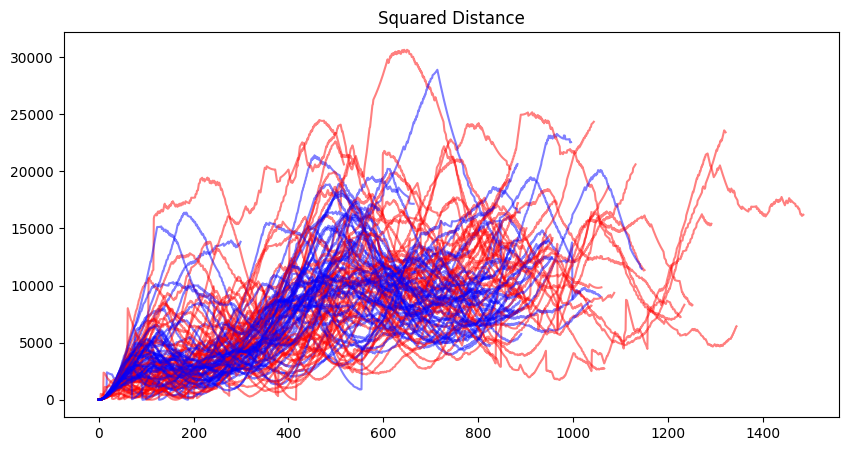

In [5]:
plt.figure(figsize=(10, 5))
for d2, name in zip(trace_distances_all, names):
    df[name] = {}
    if True: #not 'dynamic' in name:
        x = np.array([k for k in range(len(d2))]).reshape((-1, 1))
        reg = LinearRegression().fit(x, d2)
        pred = reg.predict(x)
        pad = 0
        d2 = list([0.0 for _ in range(pad)]) + list(d2)
        #print(d2)
        filtered = gaussian_filter1d(d2, 60)[pad:]
        filtered2 = gaussian_filter1d(d2, 30)[pad:]
        filtered3 = gaussian_filter1d(d2, 5)[pad:]
        d2 = d2[pad:]
        
        color = 'red' if 'PE' in name else 'blue'
        plt.plot(d2[:-500], c=color, alpha=0.5)
        #plt.plot(pred, c='k')
        #plt.plot(filtered2, c='lightgrey')

        df[name]['dist2'] = d2
        df[name]['dist2_linreg'] = pred
        df[name]['dist2_filtered'] = filtered
        df[name]['dist2_filtered2'] = filtered2
        df[name]['dist2_filtered3'] = filtered3
        
plt.title('Squared Distance')
plt.show()

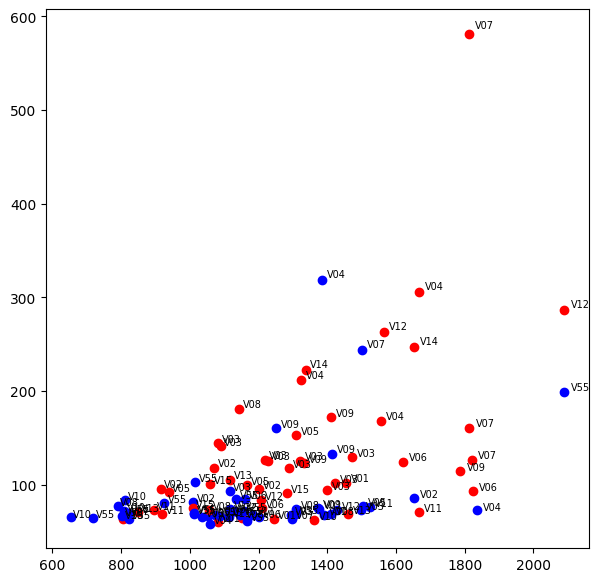

In [6]:
plt.figure(figsize=(7,7))
for name in df:
    if len(df[name]['dist2']) > 800:
        sa, ea = 10, -50
        sd, ed = 10, -50
        c = 'red' if 'PE' in name else 'blue'
        x = np.std([i-j for i, j in zip(df[name]['dist2'][sd:ed], df[name]['dist2_filtered'][sd:ed])])
        y = np.std([i-j for i, j in zip(df[name]['dist2'][sa:ea], df[name]['dist2_filtered3'][sa:ea])])
        plt.scatter(x, y, c=c)
        plt.text(x*1.01, y*1.01, name[:3], fontsize=7)

plt.show()

In [7]:
X_train, X_test = [], []
y_train, y_test = [], []
kns = 3
for b in [True, False]:
    tmpX, tmpy = [], []
    df_rand = list(df.keys())
    random.seed(3)
    random.shuffle(df_rand)
    for name in df_rand:
        if len(df[name]['dist2']) > 800:
            if (('PE' in name) == b):
                sa, ea = 10, -10
                sd, ed = 10, -10
                lbl = 1 if 'PE' in name else 0
                x = np.std([i-j for i, j in zip(df[name]['dist2'][sd:ed], df[name]['dist2_filtered'][sd:ed])])
                y = np.std([i-j for i, j in zip(df[name]['dist2'][sa:ea], df[name]['dist2_filtered3'][sa:ea])])
                tmpX.append([x, y])
                tmpy.append(lbl)
    
    X_test.extend(tmpX[-len(tmpX)//3:])
    X_train.extend(tmpX[:-len(tmpX)//3])
    #print(tmpy)
    y_test.extend(tmpy[-len(tmpy)//3:])
    y_train.extend(tmpy[:-len(tmpy)//3])

        

In [8]:
# use a Knn with k=3 see parameter tuning in our paper
clf = KNeighborsClassifier(n_neighbors=3)

clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
print(confusion_matrix(y_train, y_train_pred))

y_test_pred = clf.predict(X_test)
cm_test = confusion_matrix(y_test, y_test_pred)
print(cm_test)

acc_test = 100 * (cm_test[0, 0] + cm_test[1, 1]) / sum(sum(cm_test))
print(f'test accuracy: {acc_test:.2f}%')

[[26  7]
 [ 6 26]]
[[15  2]
 [ 8  9]]
test accuracy: 70.59%


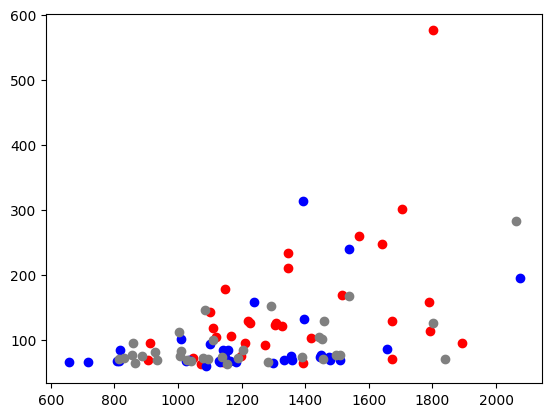

In [9]:
for X, y in zip(X_train, y_train):
    plt.scatter(X[0], X[1], c=['blue', 'red'][y])
for X in X_test:
    plt.scatter(X[0], X[1], c='grey')

#plt.plot([min(np.array(X_train)[:, 0]), max(np.array(X_train)[:, 0])], [-(clf.intercept_ + min(np.array(X_train)[:, 0])*clf.coef_[0, 0])/clf.coef_[0, 1], -(clf.intercept_ + max(np.array(X_train)[:, 0])*clf.coef_[0, 0])/clf.coef_[0, 1]], 'k')
#plt.xscale('log')
#plt.yscale('log')